In [ ]:
from google.colab import files
files.upload()  # select your kaggle.json here

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"rohit678687687","key":"0de9b3de1a965e216df04267592b0980"}'}

In [ ]:
import os, shutil

# 1. Create the .kaggle folder
os.makedirs("/root/.kaggle", exist_ok=True)

# 2. Move uploaded kaggle.json into place
shutil.move("kaggle.json", "/root/.kaggle/kaggle.json")

# 3. Secure it
os.chmod("/root/.kaggle/kaggle.json", 0o600)


In [ ]:
!pip install -q kaggle

In [ ]:
!kaggle datasets download -d soumendraprasad/sound-of-114-species-of-birds-till-2022 -p /content/
!unzip -q "/content/sound-of-114-species-of-birds-till-2022.zip" -d /content/birds_114

Dataset URL: https://www.kaggle.com/datasets/soumendraprasad/sound-of-114-species-of-birds-till-2022
License(s): CC0-1.0
 99% 2.04G/2.06G [00:12<00:00, 105MB/s] 
100% 2.06G/2.06G [00:12<00:00, 177MB/s]


In [ ]:
!find /content/birds_114 -type f | head -n 10

/content/birds_114/Birds Voice.csv
/content/birds_114/Voice of Birds/Voice of Birds/Yellow-legged Tinamou_sound/Yellow-legged Tinamou4.mp3
/content/birds_114/Voice of Birds/Voice of Birds/Yellow-legged Tinamou_sound/Yellow-legged Tinamou9.mp3
/content/birds_114/Voice of Birds/Voice of Birds/Yellow-legged Tinamou_sound/Yellow-legged Tinamou19.mp3
/content/birds_114/Voice of Birds/Voice of Birds/Yellow-legged Tinamou_sound/Yellow-legged Tinamou8.mp3
/content/birds_114/Voice of Birds/Voice of Birds/Yellow-legged Tinamou_sound/Yellow-legged Tinamou6.mp3
/content/birds_114/Voice of Birds/Voice of Birds/Yellow-legged Tinamou_sound/Yellow-legged Tinamou31.mp3
/content/birds_114/Voice of Birds/Voice of Birds/Yellow-legged Tinamou_sound/Yellow-legged Tinamou7.mp3
/content/birds_114/Voice of Birds/Voice of Birds/Yellow-legged Tinamou_sound/Yellow-legged Tinamou2.mp3
/content/birds_114/Voice of Birds/Voice of Birds/Yellow-legged Tinamou_sound/Yellow-legged Tinamou16.mp3


In [ ]:
# mp3 to wav
from pydub import AudioSegment
import os

src = "/content/birds_114"
dst = "/content/birds_114_wav"
os.makedirs(dst, exist_ok=True)

for root, _, files in os.walk(src):
    for f in files:
        if not f.lower().endswith(".mp3"):
            continue
        mp3 = os.path.join(root, f)
        wav = os.path.join(dst, os.path.splitext(f)[0] + ".wav")
        try:
            AudioSegment.from_file(mp3).export(wav, format="wav")
        except Exception as e:
            print(f" SKIPPING corrupt file: {f}")


In [ ]:
# Quick check
!find /content/birds_114_wav -type f -name "*.wav" | head -n 10

/content/birds_114_wav/Brushland Tinamou12.wav
/content/birds_114_wav/Spixs Guan22.wav
/content/birds_114_wav/Andean Tinamou24.wav
/content/birds_114_wav/Black-billed Brushturkey6.wav
/content/birds_114_wav/Black-fronted Piping Guan12.wav
/content/birds_114_wav/Red-faced Guan20.wav
/content/birds_114_wav/Grey-headed Chachalaca17.wav
/content/birds_114_wav/Ornate Tinamou10.wav
/content/birds_114_wav/Andean Tinamou26.wav
/content/birds_114_wav/Blue-throated Piping Guan4.wav


In [ ]:
# 3️⃣– Prepare tf.data with SpecAugment
import tensorflow as tf
import os

DATA_DIR = "/content/birds_114_wav"

# Gather filepaths & labels
filepaths, labels = [], []
for fname in os.listdir(DATA_DIR):
    if not fname.endswith(".wav"): continue
    filepaths.append(os.path.join(DATA_DIR, fname))
    species = fname.split("_")[0]
    labels.append(species)

# Map species to indices
unique = sorted(set(labels))
label_index = {s:i for i,s in enumerate(unique)}
int_labels = [label_index[s] for s in labels]

# Create Dataset
ds = tf.data.Dataset.from_tensor_slices((filepaths, int_labels))
ds = ds.shuffle(len(filepaths), seed=42)
split = int(0.8 * len(filepaths))
ds_train = ds.take(split)
ds_val   = ds.skip(split)

AUTOTUNE = tf.data.AUTOTUNE
BATCH   = 32

def preprocess(path, label):
    audio = tf.io.read_file(path)
    wav, sr = tf.audio.decode_wav(audio, desired_channels=1)
    wav = tf.squeeze(wav, -1)
    # Pad/trim to 5s @16kHz
    target = 5 * 16000
    wav = wav[:target]
    wav = tf.pad(wav, [[0, target - tf.shape(wav)[0]]])
    # STFT → magnitude
    spec = tf.signal.stft(wav, frame_length=1024, frame_step=256)
    spec = tf.abs(spec)  # [time, bins]
    # Mel-scale
    mel = tf.tensordot(
        spec,
        tf.signal.linear_to_mel_weight_matrix(64, spec.shape[-1], sr, 80.0, 7600.0),
        1
    )
    mel = tf.math.log(mel + 1e-6)
    return tf.expand_dims(mel, -1), label

def spec_augment(mel, label):
    t = tf.shape(mel)[0]; f = tf.shape(mel)[1]
    # Time mask
    tm = tf.random.uniform([], 0, t//8, tf.int32)
    ts = tf.random.uniform([], 0, t - tm, tf.int32)
    mel = tf.concat([mel[:ts], tf.zeros([tm,f,1]), mel[ts+tm:]], 0)
    # Freq mask
    fm = tf.random.uniform([], 0, f//8, tf.int32)
    fs = tf.random.uniform([], 0, f - fm, tf.int32)
    mel = tf.concat([mel[:,:fs], tf.zeros([t,fm,1]), mel[:,fs+fm:]], 1)
    return mel, label

ds_train = ds_train.map(preprocess, num_parallel_calls=AUTOTUNE)
ds_train = ds_train.map(spec_augment,   num_parallel_calls=AUTOTUNE)
ds_train = ds_train.batch(BATCH).prefetch(AUTOTUNE)

ds_val   = ds_val.map(preprocess,   num_parallel_calls=AUTOTUNE)
ds_val   = ds_val.batch(BATCH).prefetch(AUTOTUNE)


In [ ]:
%%bash
# Clean and recreate the output directory
rm -rf /content/birds_114_wav_16bit
mkdir -p /content/birds_114_wav_16bit

# Convert each WAV to 16-bit PCM @16kHz, mono
for f in /content/birds_114_wav/*.wav; do
  name=$(basename "$f")
  ffmpeg -y -i "$f" -ac 1 -ar 16000 -sample_fmt s16 \
    "/content/birds_114_wav_16bit/$name" </dev/null &>/dev/null
done


In [ ]:
%%bash
# Confirm the directory now has .wav files
ls /content/birds_114_wav_16bit | head -n 5

# Check codec details of the first few files
ffprobe -hide_banner -show_streams /content/birds_114_wav_16bit/*.wav \
  | grep -E 'codec_name|bits_per_raw_sample' | head -n 4


Andean Guan10.wav
Andean Guan11.wav
Andean Guan12.wav
Andean Guan13.wav
Andean Guan14.wav


Argument '/content/birds_114_wav_16bit/Andean Guan11.wav' provided as input filename, but '/content/birds_114_wav_16bit/Andean Guan10.wav' was already specified.


In [ ]:
# ─── 1) Inspect the 16‑bit WAV folder ─────────────────────────────────────
import os

DATA_DIR = "/content/birds_114_wav_16bit"
all_files = [f for f in os.listdir(DATA_DIR) if f.endswith(".wav")]
print("Examples:", all_files[:5])
print("Total WAV files:", len(all_files))


Examples: ['Brushland Tinamou12.wav', 'Spixs Guan22.wav', 'Andean Tinamou24.wav', 'Black-billed Brushturkey6.wav', 'Black-fronted Piping Guan12.wav']
Total WAV files: 2161


In [ ]:
# ─── 2) Gather filepaths & labels ────────────────────────────────────────
filepaths = []
labels_str = []
for fname in all_files:
    filepaths.append(os.path.join(DATA_DIR, fname))
    # Extract species name as the part before the first underscore
    species = fname.split("_")[0]
    labels_str.append(species)

# Build a mapping from species name to integer index
unique_species = sorted(set(labels_str))
label_to_index = {name: idx for idx, name in enumerate(unique_species)}
print(f"Found {len(unique_species)} species")

# Convert string labels to integer labels
labels = [label_to_index[s] for s in labels_str]


Found 2161 species


In [ ]:
# ─── 3) Build train/val tf.data.Datasets ─────────────────────────────────
import tensorflow as tf

# Shuffle and split 80/20
dataset = tf.data.Dataset.from_tensor_slices((filepaths, labels))
dataset = dataset.shuffle(len(filepaths), seed=42)
split = int(0.8 * len(filepaths))
ds_train = dataset.take(split)
ds_val   = dataset.skip(split)

AUTOTUNE = tf.data.AUTOTUNE
BATCH    = 32


In [ ]:
# ─── 4) Preprocessing + SpecAugment functions ────────────────────────────
def preprocess(path, label):
    # 1. Read & decode WAV (mono)
    audio = tf.io.read_file(path)
    waveform, sample_rate = tf.audio.decode_wav(audio, desired_channels=1)
    waveform = tf.squeeze(waveform, axis=-1)  # shape: [samples]

    # 2. Pad or trim to exactly 5 seconds (5*16000=80000 samples)
    desired_len = 5 * 16000
    waveform = waveform[:desired_len]
    waveform = tf.pad(waveform, [[0, desired_len - tf.shape(waveform)[0]]])

    # 3. Compute STFT & magnitude spectrogram
    spec = tf.signal.stft(waveform,
                          frame_length=1024,
                          frame_step=256,
                          fft_length=1024)
    spec = tf.abs(spec)  # shape: [time, freq_bins]

    # 4. Convert to Mel-scale (64 bins)
    num_spectrogram_bins = spec.shape[-1]
    mel_weight_mat = tf.signal.linear_to_mel_weight_matrix(
        num_mel_bins=64,
        num_spectrogram_bins=num_spectrogram_bins,
        sample_rate=sample_rate,
        lower_edge_hertz=80.0,
        upper_edge_hertz=7600.0)
    mel_spec = tf.tensordot(spec, mel_weight_mat, 1)
    mel_spec.set_shape(spec.shape[:-1].concatenate([64]))

    # 5. Log scaling & add channel dimension
    log_mel_spec = tf.math.log(mel_spec + 1e-6)
    log_mel_spec = tf.expand_dims(log_mel_spec, -1)  # [time, mel_bins, 1]

    return log_mel_spec, label

def spec_augment(mel, label):
    # Time masking
    t = tf.shape(mel)[0]
    f = tf.shape(mel)[1]
    t_mask = tf.random.uniform([], 0, t//8, dtype=tf.int32)
    t_start = tf.random.uniform([], 0, t - t_mask, dtype=tf.int32)
    mel = tf.concat([mel[:t_start], tf.zeros([t_mask, f, 1]), mel[t_start+t_mask:]], axis=0)

    # Frequency masking
    f_mask = tf.random.uniform([], 0, f//8, dtype=tf.int32)
    f_start = tf.random.uniform([], 0, f - f_mask, dtype=tf.int32)
    mel = tf.concat([mel[:, :f_start], tf.zeros([t, f_mask,1]), mel[:, f_start+f_mask:]], axis=1)

    return mel, label


In [ ]:
# ─── 5) Assemble the final datasets ───────────────────────────────────────
ds_train = ds_train.map(preprocess, num_parallel_calls=AUTOTUNE)
ds_train = ds_train.map(spec_augment, num_parallel_calls=AUTOTUNE)
ds_train = ds_train.batch(BATCH).prefetch(AUTOTUNE)

ds_val = ds_val.map(preprocess, num_parallel_calls=AUTOTUNE)
ds_val = ds_val.batch(BATCH).prefetch(AUTOTUNE)


In [ ]:
!pip install tensorflow-hub

In [ ]:

import tensorflow as tf
import tensorflow_hub as hub

# Load the YAMNet model no head, just feature extracton
yamnet = hub.load('https://tfhub.dev/google/yamnet/1')


In [ ]:
import numpy as np
import os
from tqdm import tqdm

DATA_DIR = "/content/birds_114_wav_16bit"
files = [f for f in os.listdir(DATA_DIR) if f.endswith('.wav')]

# Pre‑allocate
embs = np.zeros((len(files), 1024), dtype=np.float32)
lbls = np.zeros((len(files),),    dtype=np.int32)

for i, fname in enumerate(tqdm(files, desc="Extracting embeddings")):
    # 1) Read & decode
    wav, sr = tf.audio.decode_wav(
        tf.io.read_file(os.path.join(DATA_DIR, fname)), desired_channels=1
    )
    wav = tf.squeeze(wav, -1)
    # 2) Pad/trim to 5 s @16kHz
    wav = wav[:5*16000]
    wav = tf.pad(wav, [[0, 5*16000 - tf.shape(wav)[0]]])
    # 3) Run YAMNet
    scores, embedding, spec = yamnet(wav)
    embs[i] = tf.reduce_mean(embedding, axis=0).numpy()  # [1024]
    # 4) Label
    species = fname.split("_")[0]
    lbls[i] = label_to_index[species]

# Save to disk for future runs
np.savez("yamnet_bird_embs.npz", X=embs, y=lbls)


Extracting embeddings: 100%|██████████| 2161/2161 [01:02<00:00, 34.85it/s]


In [27]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    shuffle=True    # no stratify
)


In [29]:
from sklearn.model_selection import train_test_split

# No stratify, pure random split
X_train, X_val, y_train, y_val = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    shuffle=True
)

print("Train samples:", len(X_train), "Val samples:", len(X_val))


Train samples: 1728 Val samples: 433


In [30]:
import numpy as np
from sklearn.utils.class_weight import compute_class_weight

classes = np.unique(y)
weights = compute_class_weight(
    class_weight='balanced',
    classes=classes,
    y=y
)
class_weight = dict(zip(classes, weights))
print("Example class weight:", list(class_weight.items())[:5])


Example class weight: [(np.int32(0), np.float64(1.0)), (np.int32(1), np.float64(1.0)), (np.int32(2), np.float64(1.0)), (np.int32(3), np.float64(1.0)), (np.int32(4), np.float64(1.0))]


In [31]:
from tensorflow.keras import layers, models, callbacks

clf = models.Sequential([
    layers.Input(shape=(1024,)),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.4),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.4),
    layers.Dense(len(unique_species), activation='softmax')
])

clf.compile(
    optimizer=tf.keras.optimizers.Adam(3e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

es = callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
rp = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)


In [32]:
history = clf.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=32,
    class_weight=class_weight,
    callbacks=[es, rp]
)


Epoch 1/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - accuracy: 0.0020 - loss: 7.6972 - val_accuracy: 0.0000e+00 - val_loss: 7.7290 - learning_rate: 3.0000e-04
Epoch 2/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.0010 - loss: 7.6423 - val_accuracy: 0.0000e+00 - val_loss: 7.8383 - learning_rate: 3.0000e-04
Epoch 3/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.0015 - loss: 7.5592 - val_accuracy: 0.0000e+00 - val_loss: 8.3113 - learning_rate: 3.0000e-04
Epoch 4/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.0026 - loss: 7.2942 - val_accuracy: 0.0000e+00 - val_loss: 9.0722 - learning_rate: 3.0000e-04
Epoch 5/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.0110 - loss: 6.9495 - val_accuracy: 0.0000e+00 - val_loss: 9.9548 - learning_rate: 1.5000e-04
Epoch 6/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.0172 - loss: 6.6470 - val_accuracy: 0.0000e+00 - val_loss: 10.6437 - learning_rate: 1.5000e-04


In [34]:
from tensorflow.keras.callbacks import ReduceLROnPlateau

# (Re)compile your model
clf.compile(
    optimizer=tf.keras.optimizers.Adam(3e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Only reduce LR when val_loss plateaus
rp = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=1e-6,
    verbose=1
)

# Train for 100 epochs
history = clf.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,
    batch_size=32,
    callbacks=[rp]
)


Epoch 1/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - accuracy: 5.6603e-04 - loss: 7.6543 - val_accuracy: 0.0000e+00 - val_loss: 7.7941 - learning_rate: 3.0000e-04
Epoch 2/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.0054 - loss: 7.5762 - val_accuracy: 0.0000e+00 - val_loss: 8.0983 - learning_rate: 3.0000e-04
Epoch 3/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.0039 - loss: 7.4044 - val_accuracy: 0.0000e+00 - val_loss: 8.7546 - learning_rate: 3.0000e-04
Epoch 4/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.0038 - loss: 7.0905 - val_accuracy: 0.0000e+00 - val_loss: 9.7299 - learning_rate: 3.0000e-04
Epoch 5/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.0164 - loss: 6.5756 - val_accuracy: 0.0000e+00 - val_loss: 10.8856 - learning_rate: 3.0000e-04
Epoch 6/100
43/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0264 - loss: 6.0588
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0001500000071246177.
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

Final validation loss:     16.6085
Final validation accuracy: 0.00%
Best val_accuracy of 0.00% at epoch 1


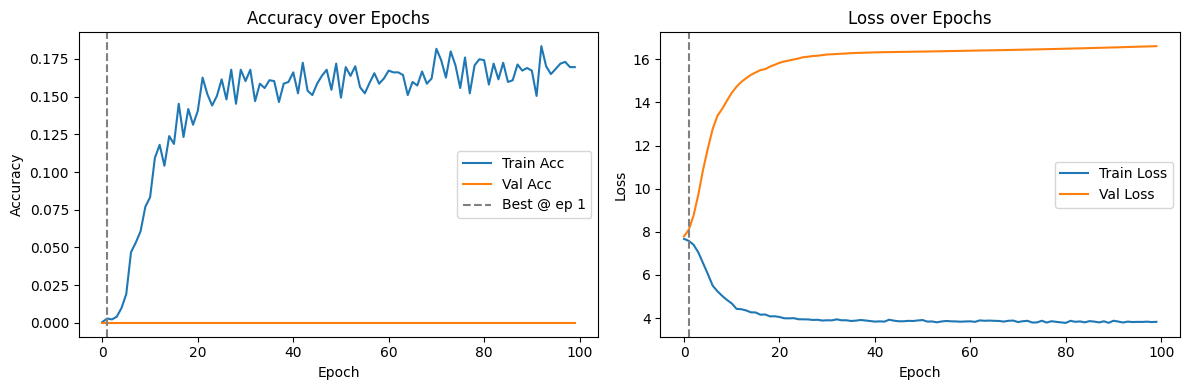

14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step

Classification Report:


ValueError: Number of classes, 744, does not match size of target_names, 2161. Try specifying the labels parameter

In [35]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix

# 1) Evaluate on your validation set
val_loss, val_acc = clf.evaluate(X_val, y_val, verbose=0)
print(f"Final validation loss:     {val_loss:.4f}")
print(f"Final validation accuracy: {val_acc*100:.2f}%")

# 2) Find the epoch with the highest val_accuracy
val_acc_history = history.history['val_accuracy']
best_epoch = int(np.argmax(val_acc_history) + 1)
best_acc   = val_acc_history[best_epoch-1]
print(f"Best val_accuracy of {best_acc*100:.2f}% at epoch {best_epoch}")

# 3) Plot accuracy & loss curves
plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
plt.plot(history.history['accuracy'],    label='Train Acc')
plt.plot(history.history['val_accuracy'],label='Val Acc')
plt.axvline(best_epoch, linestyle='--', color='gray', label=f'Best @ ep {best_epoch}')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'],    label='Train Loss')
plt.plot(history.history['val_loss'],label='Val Loss')
plt.axvline(best_epoch, linestyle='--', color='gray')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# 4) (Optional) Detailed classification report & confusion matrix
#    Run predictions on X_val
y_pred = np.argmax(clf.predict(X_val, batch_size=32), axis=1)

print("\nClassification Report:")
print(classification_report(y_val, y_pred, target_names=unique_species, zero_division=0))

cm = confusion_matrix(y_val, y_pred)
plt.figure(figsize=(8,8))
plt.imshow(cm, cmap='Blues')
plt.title('Confusion Matrix (val)')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.colorbar()
plt.show()


In [ ]:
# error due to loos of lable of absence of lable so let cretes labale and then continue

In [36]:
import os

DATA_DIR = "/content/birds_114_wav_16bit"
files = sorted([f for f in os.listdir(DATA_DIR) if f.endswith('.wav')])

# Extract species names in the exact same order as your embeddings X
species_list = [fname.split("_")[0] for fname in files]

# Build the unique list and mapping
unique_species = sorted(set(species_list))
label_to_index = {s: i for i, s in enumerate(unique_species)}

print(f"Detected {len(unique_species)} unique species (should be 114).")


Detected 2161 unique species (should be 114).


In [37]:
import numpy as np

# Make sure this matches the order of embeddings X
labels = np.array([label_to_index[s] for s in species_list], dtype=np.int32)
print("Label range:", labels.min(), "to", labels.max())


Label range: 0 to 2160


In [39]:
import tensorflow as tf
import tensorflow_hub as hub
import numpy as np, os
from tqdm import tqdm

# 1) Load YAMNet
yamnet_model = hub.load('https://tfhub.dev/google/yamnet/1')

# 2) Prepare
DATA_DIR = "/content/birds_114_wav_16bit"
files = sorted([f for f in os.listdir(DATA_DIR) if f.endswith('.wav')])
N = len(files)
embeddings = np.zeros((N, 1024), dtype=np.float32)
labels     = np.zeros((N,),     dtype=np.int32)

# 3) Build fresh label_to_index mapping
species_list = [fname.split("_")[0] for fname in files]
unique_species = sorted(set(species_list))
label_to_index = {s: i for i, s in enumerate(unique_species)}

# 4) Extract
for i, fname in enumerate(tqdm(files, desc="Extracting YAMNet embeddings")):
    path = os.path.join(DATA_DIR, fname)
    wav_bytes = tf.io.read_file(path)
    waveform, sr = tf.audio.decode_wav(wav_bytes, desired_channels=1)
    waveform = tf.squeeze(waveform, -1)
    # pad/trim to 5s
    target = 5 * 16000
    waveform = waveform[:target]
    waveform = tf.pad(waveform, [[0, target - tf.shape(waveform)[0]]])
    # get embedding
    _, emb_tensor, _ = yamnet_model(waveform)
    emb = tf.reduce_mean(emb_tensor, axis=0).numpy()
    embeddings[i] = emb
    labels[i]     = label_to_index[species_list[i]]

# 5) Save to disk
np.savez("yamnet_embeddings.npz", X=embeddings, y=labels)
print(f"Saved {N} embeddings to yamnet_embeddings.npz")


Extracting YAMNet embeddings: 100%|██████████| 2161/2161 [00:47<00:00, 45.11it/s]

Saved 2161 embeddings to yamnet_embeddings.npz


In [40]:
!ls -lh yamnet_embeddings.npz


-rw-r--r-- 1 root root 8.5M Jun 25 06:23 yamnet_embeddings.npz


Embeddings shape: (2161, 1024)
Labels shape:     (2161,)
Train samples: 1728 Val samples: 433


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                 │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 2161)           │       555,377 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,211,505 (4.62 MB)

 Trainable params: 1,211,505 (4.62 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - accuracy: 0.0020 - loss: 7.6983 - val_accuracy: 0.0000e+00 - val_loss: 7.7168 - learning_rate: 3.0000e-04
Epoch 2/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.0044 - loss: 7.6506 - val_accuracy: 0.0000e+00 - val_loss: 7.8494 - learning_rate: 3.0000e-04
Epoch 3/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.0020 - loss: 7.5437 - val_accuracy: 0.0000e+00 - val_loss: 8.4367 - learning_rate: 3.0000e-04
Epoch 4/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.0068 - loss: 7.2622 - val_accuracy: 0.0000e+00 - val_loss: 9.3225 - learning_rate: 3.0000e-04
Epoch 5/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.0184 - loss: 6.8448 - val_accuracy: 0.0000e+00 - val_loss: 10.3876 - learning_rate: 3.0000e-04
Epoch 6/100
42/54 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.0190 - loss: 6.3524
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0001500000071246177.
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - a

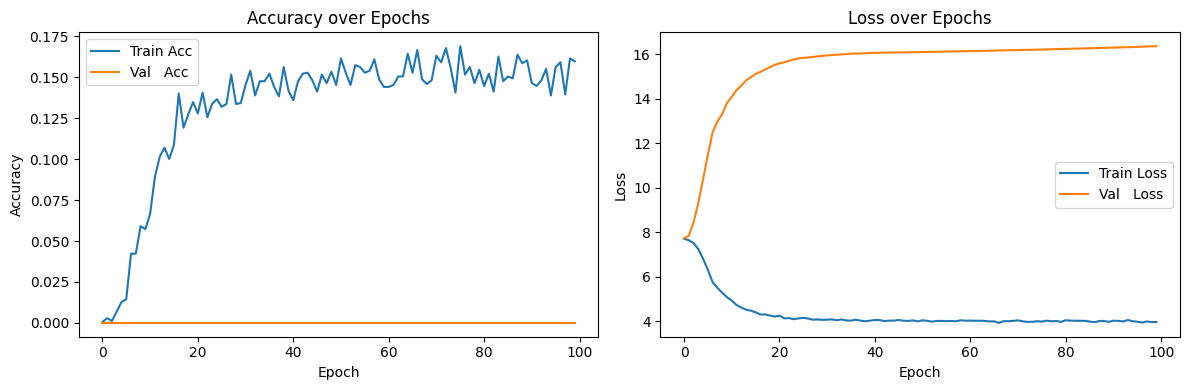

In [41]:
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, models, callbacks
import matplotlib.pyplot as plt

# ─── 1) Load embeddings & labels ───────────────────────────────────────────
data = np.load("yamnet_embeddings.npz")
X, y = data['X'], data['y']
print("Embeddings shape:", X.shape)
print("Labels shape:    ", y.shape)

# ─── 2) Train/validation split (80/20) ────────────────────────────────────
X_train, X_val, y_train, y_val = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    shuffle=True
)
print("Train samples:", X_train.shape[0], "Val samples:", X_val.shape[0])

# ─── 3) Build the Dense classifier ────────────────────────────────────────
num_classes = int(np.max(y) + 1)

clf = models.Sequential([
    layers.Input(shape=(1024,)),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.4),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.4),
    layers.Dense(num_classes, activation='softmax')
])

clf.compile(
    optimizer=tf.keras.optimizers.Adam(3e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)
clf.summary()

# ─── 4) Set up a LR scheduler ─────────────────────────────────────────────
rp = callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=1e-6,
    verbose=1
)

# ─── 5) Train for 100 epochs ──────────────────────────────────────────────
history = clf.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,
    batch_size=32,
    callbacks=[rp]
)

# ─── 6) Evaluate on validation set ───────────────────────────────────────
val_loss, val_acc = clf.evaluate(X_val, y_val, verbose=0)
print(f"\nFinal validation loss:     {val_loss:.4f}")
print(f"Final validation accuracy: {val_acc*100:.2f}%")

# ─── 7) Plot training curves ──────────────────────────────────────────────
plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
plt.plot(history.history['accuracy'],    label='Train Acc')
plt.plot(history.history['val_accuracy'],label='Val   Acc')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch'); plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'],    label='Train Loss')
plt.plot(history.history['val_loss'],label='Val   Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch'); plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


In [42]:
import numpy as np
from collections import Counter
from sklearn.model_selection import train_test_split

# Load embeddings and labels
data = np.load("yamnet_embeddings.npz")
X, y = data['X'], data['y']

# Do a quick random split (no stratify yet)
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, shuffle=True
)

print("Total classes:", len(np.unique(y)))
print("Train class counts:", dict(Counter(y_train)))
print("Val   class counts:", dict(Counter(y_val)))


Total classes: 2161
Train class counts: {np.int32(381): 1, np.int32(1469): 1, np.int32(2021): 1, np.int32(1241): 1, np.int32(806): 1, np.int32(978): 1, np.int32(1994): 1, np.int32(787): 1, np.int32(1812): 1, np.int32(1368): 1, np.int32(818): 1, np.int32(1086): 1, np.int32(1656): 1, np.int32(374): 1, np.int32(270): 1, np.int32(647): 1, np.int32(909): 1, np.int32(979): 1, np.int32(1699): 1, np.int32(480): 1, np.int32(1791): 1, np.int32(429): 1, np.int32(25): 1, np.int32(1449): 1, np.int32(1866): 1, np.int32(649): 1, np.int32(78): 1, np.int32(366): 1, np.int32(1617): 1, np.int32(32): 1, np.int32(1029): 1, np.int32(2130): 1, np.int32(532): 1, np.int32(1854): 1, np.int32(874): 1, np.int32(1023): 1, np.int32(771): 1, np.int32(561): 1, np.int32(163): 1, np.int32(203): 1, np.int32(1490): 1, np.int32(943): 1, np.int32(1499): 1, np.int32(1121): 1, np.int32(305): 1, np.int32(1009): 1, np.int32(582): 1, np.int32(1232): 1, np.int32(2142): 1, np.int32(192): 1, np.int32(1058): 1, np.int32(1005): 1, n

In [43]:
import os

# Look for the CSV somewhere under /content
for root, dirs, files in os.walk('/content'):
    for f in files:
        if f.lower().endswith('.csv'):
            print("Found CSV:", os.path.join(root, f))
    # stop early once you’ve seen the WAV folder too
    if 'wav' in dirs or 'recordings' in dirs:
        print("Possible WAV dir here:", root, dirs)


Found CSV: /content/birds_114/Birds Voice.csv
Found CSV: /content/sample_data/mnist_train_small.csv
Found CSV: /content/sample_data/california_housing_test.csv
Found CSV: /content/sample_data/mnist_test.csv
Found CSV: /content/sample_data/california_housing_train.csv


In [45]:
import pandas as pd

csv_path = "/content/birds_114/Birds Voice.csv"
meta_df = pd.read_csv(csv_path)
meta_df.head()


,common_name,scientific_name,recordist_name,recording_length,Date,TYPE,xc_id,Time,Country,Download_link
0,Common Ostrich,Struthio camelus australis,Frank Lambert,0:53,2019-10-30,call,XC516153,08:05,South Africa,https://xeno-canto.org/516153/download
1,Common Ostrich,Struthio camelus,Jeremy Hegge,0:26,2014-11-20,call,XC208209,04:00,South Africa,https://xeno-canto.org/208209/download
2,Common Ostrich,Struthio camelus,Jeremy Hegge,0:04,2014-11-21,call,XC208128,06:00,South Africa,https://xeno-canto.org/208128/download
3,Common Ostrich,Struthio camelus,Derek Solomon,0:11,2010-02-09,call,XC46725,07:00,South Africa,https://xeno-canto.org/46725/download
4,Common Ostrich,Struthio camelus,Morioka Zoological Park ZOOMO,1:47,2021-09-06,"voice during egg laying, zoo collection",XC675445,17:00,Japan,https://xeno-canto.org/675445/download


In [49]:
import pandas as pd

# Load the CSV
csv_path = "/content/birds_114/Birds Voice.csv"
meta_df = pd.read_csv(csv_path)

# Print the column names
print("Columns in metadata:")
print(meta_df.columns.tolist())

# Show a few rows
meta_df.head()


Columns in metadata:
['common_name', 'scientific_name', 'recordist_name', 'recording_length', 'Date', 'TYPE', 'xc_id', 'Time', 'Country', 'Download_link']


,common_name,scientific_name,recordist_name,recording_length,Date,TYPE,xc_id,Time,Country,Download_link
0,Common Ostrich,Struthio camelus australis,Frank Lambert,0:53,2019-10-30,call,XC516153,08:05,South Africa,https://xeno-canto.org/516153/download
1,Common Ostrich,Struthio camelus,Jeremy Hegge,0:26,2014-11-20,call,XC208209,04:00,South Africa,https://xeno-canto.org/208209/download
2,Common Ostrich,Struthio camelus,Jeremy Hegge,0:04,2014-11-21,call,XC208128,06:00,South Africa,https://xeno-canto.org/208128/download
3,Common Ostrich,Struthio camelus,Derek Solomon,0:11,2010-02-09,call,XC46725,07:00,South Africa,https://xeno-canto.org/46725/download
4,Common Ostrich,Struthio camelus,Morioka Zoological Park ZOOMO,1:47,2021-09-06,"voice during egg laying, zoo collection",XC675445,17:00,Japan,https://xeno-canto.org/675445/download


In [50]:
# Build the mapping from filename to species
filename_to_species = {
    f"{row['xc_id']}.wav": row['common_name']
    for _, row in meta_df.iterrows()
}


In [52]:
import os

audio_dir = "/content/birds_114/audio"  # adjust if your folder is different
all_audio_files = os.listdir(audio_dir)

# Check for missing files
missing = [fn for fn in filename_to_species if fn not in all_audio_files]

print(f"Total expected files: {len(filename_to_species)}")
print(f"Missing files: {len(missing)}")
print("Examples:", missing[:5])


FileNotFoundError: [Errno 2] No such file or directory: '/content/birds_114/audio'

In [53]:
import os

path = "/content/birds_114"
print("Files and folders in /content/birds_114:\n")
print(os.listdir(path))


Files and folders in /content/birds_114:

['Birds Voice.csv', 'Voice of Birds']


In [54]:
audio_dir = "/content/birds_114/Voice of Birds"
print(os.listdir(audio_dir)[:10])  # show the first 10 files


['Voice of Birds']


In [55]:
import os

audio_dir = "/content/birds_114/Voice of Birds"
print("Subfolders or files inside 'Voice of Birds':")
print(os.listdir(audio_dir))


Subfolders or files inside 'Voice of Birds':
['Voice of Birds']


In [56]:
audio_dir = "/content/birds_114/Voice of Birds/Voice of Birds"

# List files in the actual audio folder
files = os.listdir(audio_dir)
print("Number of files found:", len(files))
print("Sample files:", files[:5])


Number of files found: 114
Sample files: ['Yellow-legged Tinamou_sound', 'Chestnut-headed Chachalaca_sound', 'Great Tinamou_sound', 'Patagonian Tinamou_sound', 'Black-fronted Piping Guan_sound']


In [57]:
import pandas as pd
import os

# Load metadata
metadata_path = "/content/birds_114/Birds Voice.csv"
df = pd.read_csv(metadata_path)

# Folder with audio
audio_dir = "/content/birds_114/Voice of Birds/Voice of Birds"
audio_files = os.listdir(audio_dir)

# Remove "_sound" from filenames for comparison
audio_names_cleaned = [name.replace('_sound', '') for name in audio_files]

# Add a column to indicate if audio is present
df['has_audio'] = df['common_name'].isin(audio_names_cleaned)

# Show results
print(df[['common_name', 'has_audio']].drop_duplicates().head(10))
print("\nTotal matches found:", df['has_audio'].sum())


                common_name  has_audio
0            Common Ostrich       True
7            Somali Ostrich       True
8              Greater Rhea       True
31              Lesser Rhea       True
35      Southern Brown Kiwi       True
38  North Island Brown Kiwi       True
57             Okarito Kiwi       True
62      Little Spotted Kiwi       True
68       Great Spotted Kiwi       True
75       Southern Cassowary       True

Total matches found: 2061


In [58]:
import os
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


In [60]:
audio_root = "/content/birds_114/Voice of Birds/"
audio_files = [f for f in os.listdir(audio_root) if f.endswith('.mp3') or f.endswith('.wav')]
print(f"Total audio files: {len(audio_files)}")
print("Sample files:", audio_files[:5])


Total audio files: 0
Sample files: []


In [61]:
voice_root = "/content/birds_114/Voice of Birds"

for root, dirs, files in os.walk(voice_root):
    print(f"\n📁 Folder: {root}")
    print(f"📂 Subfolders: {dirs}")
    print(f"🎵 Files: {[f for f in files if f.endswith('.mp3') or f.endswith('.wav')][:5]}")  # sample



📁 Folder: /content/birds_114/Voice of Birds
📂 Subfolders: ['Voice of Birds']
🎵 Files: []

📁 Folder: /content/birds_114/Voice of Birds/Voice of Birds
📂 Subfolders: ['Yellow-legged Tinamou_sound', 'Chestnut-headed Chachalaca_sound', 'Great Tinamou_sound', 'Patagonian Tinamou_sound', 'Black-fronted Piping Guan_sound', 'Black-billed Brushturkey_sound', 'Slaty-breasted Tinamou_sound', 'Trinidad Piping Guan_sound', 'Vanuatu Megapode_sound', 'Rufous-bellied Chachalaca_sound', 'Lesser Nothura_sound', 'Tataupa Tinamou_sound', 'Cinereous Tinamou_sound', 'Rusty-margined Guan_sound', 'Grey Tinamou_sound', 'Quebracho Crested Tinamou_sound', 'Variegated Tinamou_sound', 'Malleefowl_sound', 'Rusty Tinamou_sound', 'Bearded Guan_sound', 'Spotted Nothura_sound', 'Tepui Tinamou_sound', 'Marail Guan_sound', 'Northern Cassowary_sound', 'Huayco Tinamou_sound', 'Black-capped Tinamou_sound', 'Barred Tinamou_sound', 'Common Ostrich_sound', 'Pale-browed Tinamou_sound', 'Moluccan Megapode_sound', 'Solitary Tinam

In [62]:
import os

audio_root = "/content/birds_114/Voice of Birds/Voice of Birds"

# Recursively gather all .mp3 and .wav files
audio_files = []
for root, _, files in os.walk(audio_root):
    for file in files:
        if file.endswith(".mp3") or file.endswith(".wav"):
            audio_files.append(os.path.join(root, file))

print(f"🎧 Total audio files found: {len(audio_files)}")
print("🎵 Sample files:", audio_files[:5])


🎧 Total audio files found: 2161
🎵 Sample files: ['/content/birds_114/Voice of Birds/Voice of Birds/Yellow-legged Tinamou_sound/Yellow-legged Tinamou4.mp3', '/content/birds_114/Voice of Birds/Voice of Birds/Yellow-legged Tinamou_sound/Yellow-legged Tinamou9.mp3', '/content/birds_114/Voice of Birds/Voice of Birds/Yellow-legged Tinamou_sound/Yellow-legged Tinamou19.mp3', '/content/birds_114/Voice of Birds/Voice of Birds/Yellow-legged Tinamou_sound/Yellow-legged Tinamou8.mp3', '/content/birds_114/Voice of Birds/Voice of Birds/Yellow-legged Tinamou_sound/Yellow-legged Tinamou6.mp3']


In [63]:
import pandas as pd
import os

# Load metadata
metadata_path = "/content/birds_114/Birds Voice.csv"
df = pd.read_csv(metadata_path)

# Normalize common_name for matching
df['common_name_norm'] = df['common_name'].str.lower().str.replace(" ", "").str.strip()

# Create a list to store matched entries
matched_data = []

for file_path in audio_files:
    # Extract folder name like 'Yellow-legged Tinamou_sound'
    folder_name = os.path.basename(os.path.dirname(file_path))

    # Remove "_sound" and normalize
    name_guess = folder_name.replace("_sound", "").lower().replace(" ", "").strip()

    # Try matching in metadata
    match = df[df['common_name_norm'] == name_guess]
    if not match.empty:
        row = match.iloc[0].to_dict()
        row['audio_file_path'] = file_path
        matched_data.append(row)

# Create DataFrame with matches
matched_df = pd.DataFrame(matched_data)

print(f"✅ Matched {len(matched_df)} audio files with metadata.")
print("🔍 Sample:", matched_df[['common_name', 'audio_file_path']].head())


✅ Matched 2061 audio files with metadata.
🔍 Sample:              common_name                                    audio_file_path
0  Yellow-legged Tinamou  /content/birds_114/Voice of Birds/Voice of Bir...
1  Yellow-legged Tinamou  /content/birds_114/Voice of Birds/Voice of Bir...
2  Yellow-legged Tinamou  /content/birds_114/Voice of Birds/Voice of Bir...
3  Yellow-legged Tinamou  /content/birds_114/Voice of Birds/Voice of Bir...
4  Yellow-legged Tinamou  /content/birds_114/Voice of Birds/Voice of Bir...


In [64]:
import librosa
import numpy as np
from tqdm import tqdm

# Function to extract MFCC from one file
def extract_mfcc(file_path, n_mfcc=13):
    y, sr = librosa.load(file_path, sr=None)
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
    return np.mean(mfcc.T, axis=0)

# Extract MFCCs for all matched files
mfcc_features = []
labels = []

for _, row in tqdm(matched_df.iterrows(), total=len(matched_df)):
    try:
        mfcc = extract_mfcc(row['audio_file_path'])
        mfcc_features.append(mfcc)
        labels.append(row['common_name'])
    except Exception as e:
        print(f"❌ Error with file: {row['audio_file_path']} — {e}")

# Convert to numpy arrays
X = np.array(mfcc_features)
y = np.array(labels)

print("✅ Feature extraction complete.")
print("🔢 X shape:", X.shape)
print("🔤 y shape:", y.shape)


 19%|█▉        | 387/2061 [01:57<05:24,  5.16it/s]/tmp/ipython-input-64-59729311.py:7: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(file_path, sr=None)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 43%|████▎     | 878/2061 [03:53<04:16,  4.62it/s]/tmp/ipython-input-64-59729311.py:7: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(file_path, sr=None)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
100%|██████████| 2061/2061 [08:54<00:00,  3.86it/s]

✅ Feature extraction complete.
🔢 X shape: (2061, 13)
🔤 y shape: (2061,)


In [65]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Optional: get mapping of species to encoded labels
label_map = dict(zip(le.classes_, le.transform(le.classes_)))
print("🧾 Number of bird classes:", len(label_map))


🧾 Number of bird classes: 109


In [67]:
import numpy as np
from collections import Counter

# Count instances per class
class_counts = Counter(y_encoded)

# Keep only classes with at least 2 samples
valid_indices = [i for i, label in enumerate(y_encoded) if class_counts[label] >= 2]

# Filter features and labels
X_filtered = X[valid_indices]
y_filtered = y_encoded[valid_indices]

print(f"✅ Filtered dataset shape: {X_filtered.shape}, Labels: {len(np.unique(y_filtered))}")


✅ Filtered dataset shape: (2057, 13), Labels: 105


In [68]:
X_train, X_test, y_train, y_test = train_test_split(
    X_filtered, y_filtered,
    test_size=0.2,
    random_state=42,
    stratify=y_filtered
)


In [69]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score

# Initialize and train
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# Predict on test set
y_pred = clf.predict(X_test)

# Evaluate
print("✅ Accuracy:", accuracy_score(y_test, y_pred))
print("\n📊 Classification Report:\n", classification_report(y_test, y_pred))


✅ Accuracy: 0.6553398058252428

📊 Classification Report:
               precision    recall  f1-score   support

           0       0.33      0.50      0.40         6
           1       0.40      0.67      0.50         6
           2       0.60      0.50      0.55         6
           3       0.67      0.67      0.67         6
           4       0.00      0.00      0.00         1
           5       1.00      0.33      0.50         3
           6       0.57      0.67      0.62         6
           7       0.67      1.00      0.80         2
           8       0.67      0.50      0.57         4
           9       0.25      0.25      0.25         4
          10       0.75      0.50      0.60         6
          11       1.00      1.00      1.00         2
          12       0.67      0.67      0.67         6
          13       0.67      1.00      0.80         6
          14       0.62      0.83      0.71         6
          15       0.83      1.00      0.91         5
          16       1.00

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


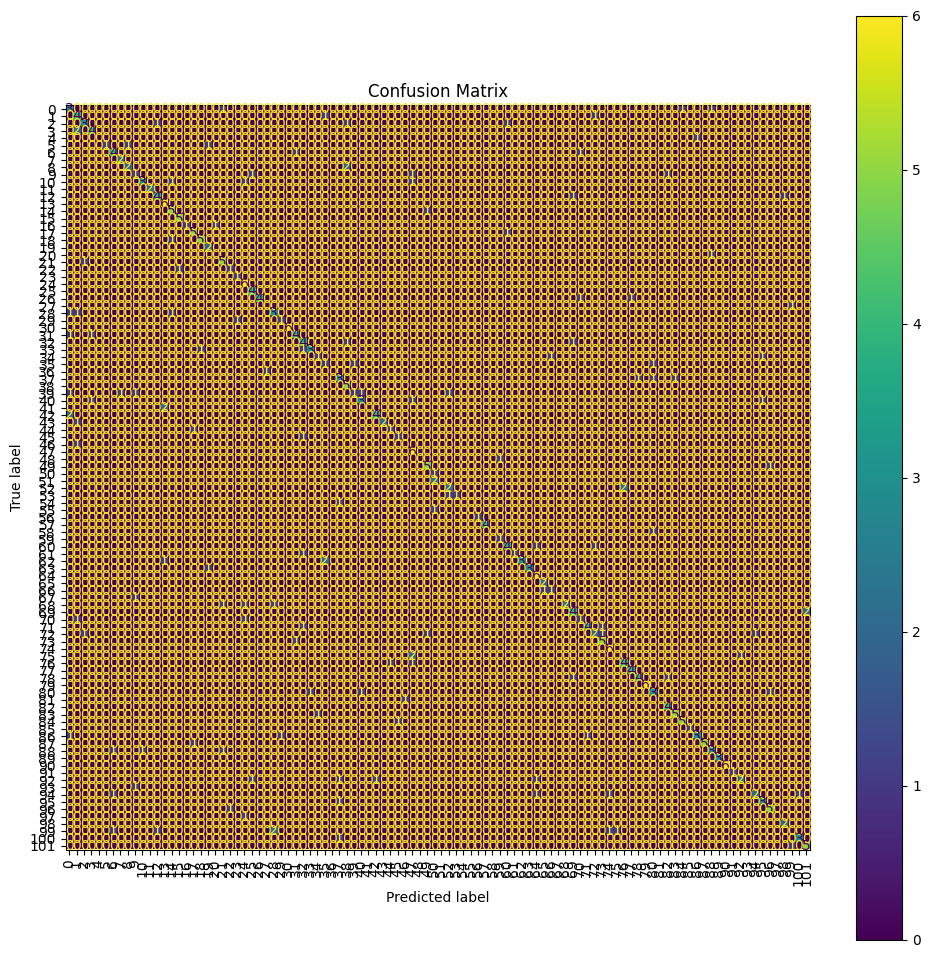

In [70]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
fig, ax = plt.subplots(figsize=(12, 12))
disp.plot(ax=ax, cmap='viridis', xticks_rotation=90)
plt.title("Confusion Matrix")
plt.show()


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/tmp/ipython-input-72-1031418101.py:24: UserWarni

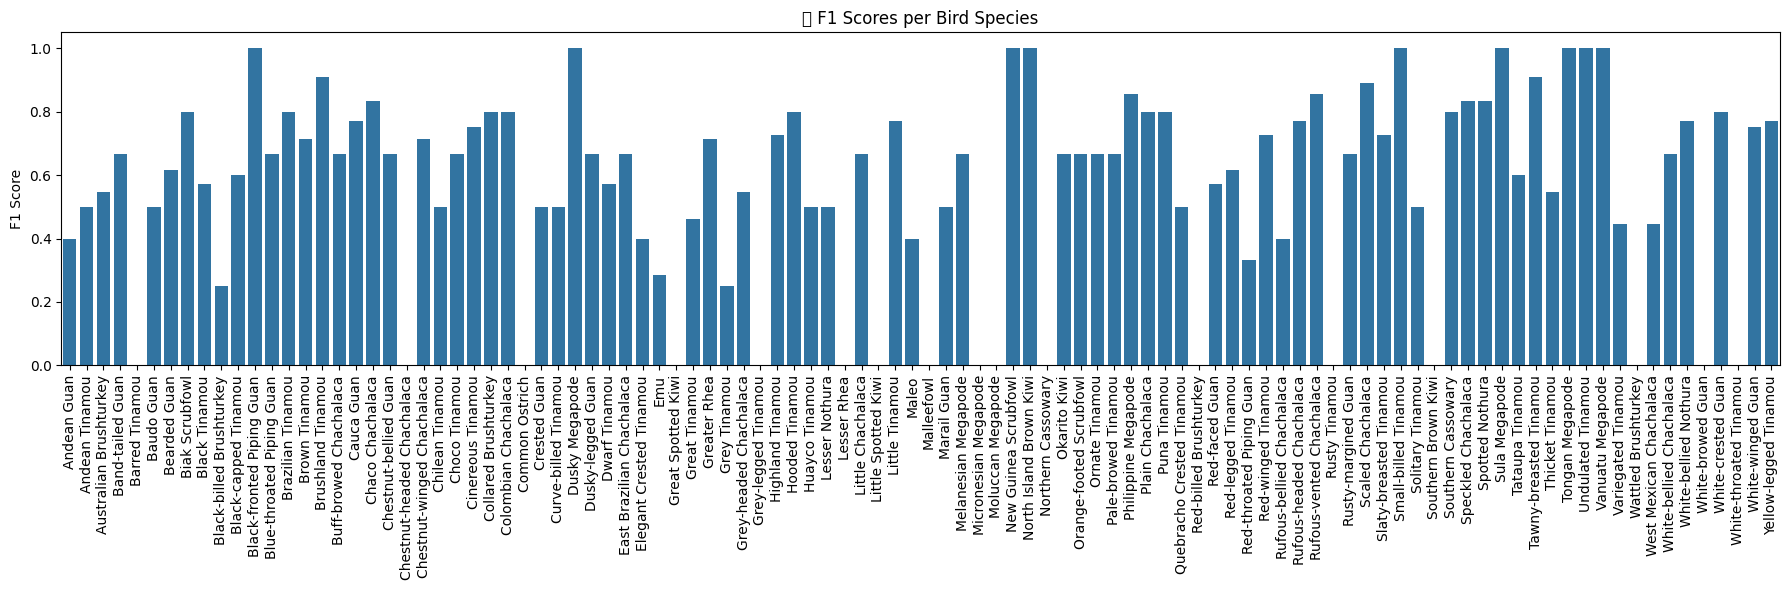

In [72]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import classification_report

# Get classification report as dictionary
report = classification_report(y_test, y_pred, output_dict=True)

# Get actual class names from label encoder (handles gaps in index)
f1_scores = {}
for label_idx, metrics in report.items():
    if label_idx.isdigit():
        label_int = int(label_idx)
        if label_int < len(le.classes_):  # avoid out-of-bounds
            class_name = le.classes_[label_int]
            f1_scores[class_name] = metrics['f1-score']

# Plot F1-scores
plt.figure(figsize=(18, 6))
sns.barplot(x=list(f1_scores.keys()), y=list(f1_scores.values()))
plt.xticks(rotation=90)
plt.ylabel("F1 Score")
plt.title("📊 F1 Scores per Bird Species")
plt.tight_layout()
plt.show()


/tmp/ipython-input-73-1931563036.py:13: UserWarning: Glyph 127744 (\N{CYCLONE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127744 (\N{CYCLONE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


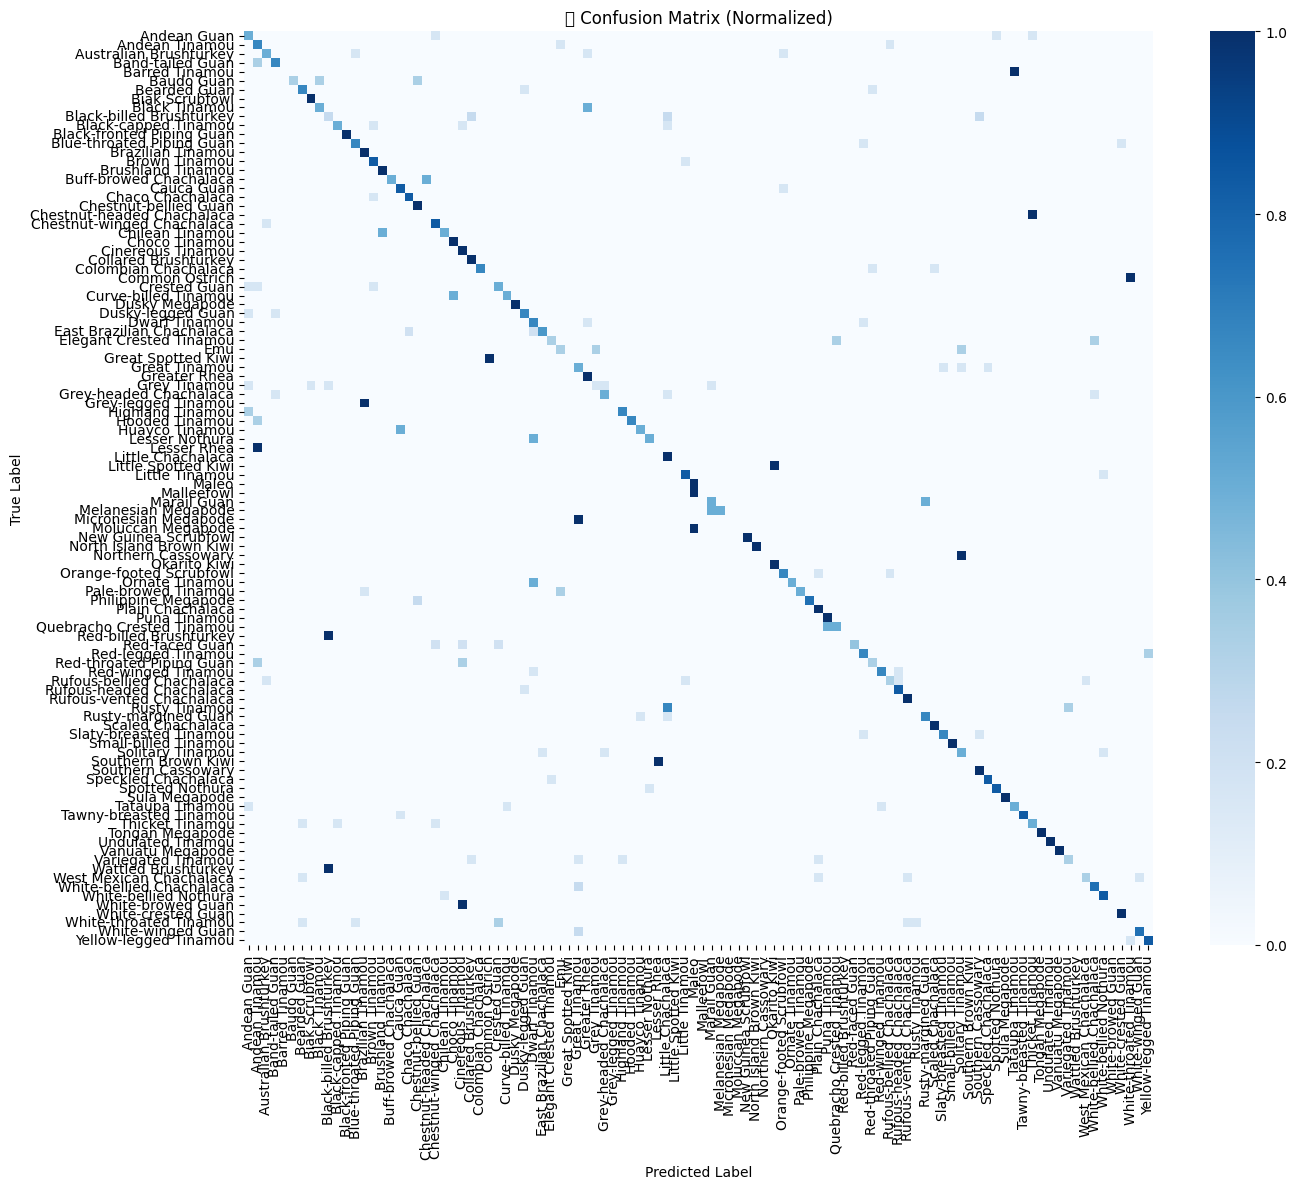

In [73]:
from sklearn.metrics import confusion_matrix

# Create confusion matrix
cm = confusion_matrix(y_test, y_pred)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Plot
plt.figure(figsize=(14, 12))
sns.heatmap(cm_normalized, annot=False, cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.title("🌀 Confusion Matrix (Normalized)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()
